# Transfer Learning - resnet50 with Adam optimizer

- This notebook explores transfer learning using the resnet50 model, where the feature extraction layers are kept frozen using the default weights and only the classifier is changed and retrained.

In [1]:
from pathlib import Path
import sys
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, models
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from datetime import datetime

# Add project root to sys.path if it does not exist
project_root = Path().resolve().parents[0]
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

from src.data.custom_dataset import CustomDataset
from utils.utils import create_logger

In [ ]:
model_variant = "resnet50_adam"
timestamp = datetime.now().strftime("%d-%m-%Y-%H-%M")

In [3]:
logging_config_path = project_root / "conf" / "logger_conf.yml"
logs_dir = project_root / "logs"
logs_dir.mkdir(parents=True, exist_ok=True)
log_filename = project_root / "logs" / f"trnfl_{model_variant}_{timestamp}.log"

In [4]:
# Initialize logger
logger = create_logger(str(logging_config_path), str(log_filename))

In [5]:
# Log to confirm setup
logger.info(f"Logging initialized. Log file: {log_filename}")

[02/01/25 11:24:49] INFO     INFO - Logging initialized. Log file:                                   ]8;id=437913;file:///var/folders/jv/vqyftcs92v5_1kzvbv8kdcx40000gn/T/ipykernel_1471/693054657.py\693054657.py]8;;\:]8;id=999495;file:///var/folders/jv/vqyftcs92v5_1kzvbv8kdcx40000gn/T/ipykernel_1471/693054657.py#2\2]8;;\
                             /Users/jas/Documents/car-classification-api/logs/trnfl_resnet50_adam_01               
                             -02-2025-11-24.log                                                                    

In [6]:
# Define augmentations to be carried out
train_transformers = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    # transforms.RandomAffine(degrees=(20, 70), translate=(0.1, 0.2)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transformers = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transformers = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [7]:
train_dir = project_root / "data" / "train"

In [8]:
# Load the train dataset
train_data = ImageFolder(root=str(train_dir))

# Extract labels
labels = [train_data.targets[idx] for idx in range(len(train_data))]

# Get class mapping
class_mapping = {idx: class_name for idx, class_name in enumerate(train_data.classes)}

In [9]:
# Stratified split into train and val sets
train_indices, val_indices = train_test_split(
    range(len(train_data)), 
    test_size=0.2, 
    stratify=labels, 
    random_state=42
)

In [10]:
# Define train and validation datasets with separate transforms
train_dataset = CustomDataset(train_data, train_indices, transform=train_transformers)
val_dataset = CustomDataset(train_data, val_indices, transform=val_transformers)

In [11]:
# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [12]:
# Load pre-trained model, ResNet
model = models.resnet50(weights='DEFAULT')

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /Users/jas/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100.0%


In [13]:
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [14]:
# Modify final layer
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, len(train_data.classes))

In [15]:
logger.info(model)

[02/01/25 11:24:51] INFO     INFO - ResNet(                                                         ]8;id=87995;file:///var/folders/jv/vqyftcs92v5_1kzvbv8kdcx40000gn/T/ipykernel_1471/1427801074.py\1427801074.py]8;;\:]8;id=222;file:///var/folders/jv/vqyftcs92v5_1kzvbv8kdcx40000gn/T/ipykernel_1471/1427801074.py#1\1]8;;\
                               (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2),                           
                             padding=(3, 3), bias=False)                                                           
                               (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True,                        
                             track_running_stats=True)                                                             
                               (relu): ReLU(inplace=True)                                                          
                               (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1,                
                             ceil_mode=False)                                                                      
                               (layer1): Sequential(                                                               
                                 (0): Bottleneck(                                                                  
                                   (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1),                      
                             bias=False)                                                                           
                                   (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True,                    
                             track_running_stats=True)                                                             
                                   (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1),                      
                             padding=(1, 1), bias=False)                                                           
                                   (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True,                    
                             track_running_stats=True)                                                             
                                   (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1),                     
                             bias=False)                                                                           
                                   (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True,                   
                             track_running_stats=True)                                                             
                                   (relu): ReLU(inplace=True)                                                      
                                   (downsample): Sequential(                                                       
                                     (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1),                       
                             bias=False)                                                                           
                                     (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True,                   
                             track_running_stats=True)                                                             
                                   )                                                                               
                                 )                                                                                 
                                 (1): Bottleneck(                                                                  
                                   (conv1): Conv2d(256, 64, kernel_size=(1, 1), stride=(1, 1),                     
                             bias=False)                                    

In [16]:
len(train_data.classes)

196

In [17]:
# Freeze all layers except the final fully connected layer
for name, param in model.named_parameters():
    if not name.startswith("fc"):  # Freeze everything except the final layer
        param.requires_grad = False

In [18]:
# Check for MPS support
if torch.backends.mps.is_available():
    device = torch.device("mps")  # Use MPS (Metal Performance Shaders)
else:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # Fallback to CUDA or CPU

# Move model to the selected device
model = model.to(device)
logger.info(f"Using device: {device}")

                    INFO     INFO - Using device: mps                                               ]8;id=646942;file:///var/folders/jv/vqyftcs92v5_1kzvbv8kdcx40000gn/T/ipykernel_1471/1037915986.py\1037915986.py]8;;\:]8;id=268301;file:///var/folders/jv/vqyftcs92v5_1kzvbv8kdcx40000gn/T/ipykernel_1471/1037915986.py#9\9]8;;\

In [19]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)

# Training loop + eval on val
epochs = 10

train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []
best_val_loss = float('inf')

for epoch in range(epochs):
    # Training 
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the gradients
        optimizer.zero_grad()
        # Forward
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        # Backward
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Predictions for training accuracy
        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_accuracy = 100 * correct_train / total_train
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)


    # Val
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            # Predictions for val accuracy
            _, predicted = torch.max(outputs, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_loss /= len(val_loader)
    val_accuracy = 100 * correct_val / total_val
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    
    # Print metrics 
    logger.info(f"Epoch {epoch+1}/{epochs}")
    logger.info(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, Correct Predictions: {correct_train}/{total_train}")
    logger.info(f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%, Correct Predictions: {correct_val}/{total_val}")

[02/01/25 11:26:58] INFO     INFO - Epoch 1/10                                                     ]8;id=164298;file:///var/folders/jv/vqyftcs92v5_1kzvbv8kdcx40000gn/T/ipykernel_1471/1622717551.py\1622717551.py]8;;\:]8;id=316438;file:///var/folders/jv/vqyftcs92v5_1kzvbv8kdcx40000gn/T/ipykernel_1471/1622717551.py#67\67]8;;\

                    INFO     INFO - Train Loss: 4.9975, Train Accuracy: 4.88%, Correct             ]8;id=695504;file:///var/folders/jv/vqyftcs92v5_1kzvbv8kdcx40000gn/T/ipykernel_1471/1622717551.py\1622717551.py]8;;\:]8;id=868676;file:///var/folders/jv/vqyftcs92v5_1kzvbv8kdcx40000gn/T/ipykernel_1471/1622717551.py#68\68]8;;\
                             Predictions: 318/6515                                                                 

                    INFO     INFO - Val Loss: 4.6311, Val Accuracy: 12.40%, Correct Predictions:   ]8;id=505848;file:///var/folders/jv/vqyftcs92v5_1kzvbv8kdcx40000gn/T/ipykernel_1471/1622717551.py\1622717551.py]8;;\:]8;id=456849;file:///var/folders/jv/vqyftcs92v5_1kzvbv8kdcx40000gn/T/ipykernel_1471/1622717551.py#69\69]8;;\
                             202/1629                                                                              

[02/01/25 11:29:55] INFO     INFO - Epoch 2/10                                                     ]8;id=315449;file:///var/folders/jv/vqyftcs92v5_1kzvbv8kdcx40000gn/T/ipykernel_1471/1622717551.py\1622717551.py]8;;\:]8;id=762963;file:///var/folders/jv/vqyftcs92v5_1kzvbv8kdcx40000gn/T/ipykernel_1471/1622717551.py#67\67]8;;\

                    INFO     INFO - Train Loss: 4.2872, Train Accuracy: 22.55%, Correct            ]8;id=741587;file:///var/folders/jv/vqyftcs92v5_1kzvbv8kdcx40000gn/T/ipykernel_1471/1622717551.py\1622717551.py]8;;\:]8;id=355313;file:///var/folders/jv/vqyftcs92v5_1kzvbv8kdcx40000gn/T/ipykernel_1471/1622717551.py#68\68]8;;\
                             Predictions: 1469/6515                                                                

                    INFO     INFO - Val Loss: 4.2609, Val Accuracy: 16.88%, Correct Predictions:   ]8;id=984453;file:///var/folders/jv/vqyftcs92v5_1kzvbv8kdcx40000gn/T/ipykernel_1471/1622717551.py\1622717551.py]8;;\:]8;id=680284;file:///var/folders/jv/vqyftcs92v5_1kzvbv8kdcx40000gn/T/ipykernel_1471/1622717551.py#69\69]8;;\
                             275/1629                                                                              

[02/01/25 11:33:07] INFO     INFO - Epoch 3/10                                                     ]8;id=632363;file:///var/folders/jv/vqyftcs92v5_1kzvbv8kdcx40000gn/T/ipykernel_1471/1622717551.py\1622717551.py]8;;\:]8;id=666465;file:///var/folders/jv/vqyftcs92v5_1kzvbv8kdcx40000gn/T/ipykernel_1471/1622717551.py#67\67]8;;\

                    INFO     INFO - Train Loss: 3.8177, Train Accuracy: 34.00%, Correct            ]8;id=866963;file:///var/folders/jv/vqyftcs92v5_1kzvbv8kdcx40000gn/T/ipykernel_1471/1622717551.py\1622717551.py]8;;\:]8;id=902675;file:///var/folders/jv/vqyftcs92v5_1kzvbv8kdcx40000gn/T/ipykernel_1471/1622717551.py#68\68]8;;\
                             Predictions: 2215/6515                                                                

                    INFO     INFO - Val Loss: 3.9682, Val Accuracy: 20.32%, Correct Predictions:   ]8;id=895219;file:///var/folders/jv/vqyftcs92v5_1kzvbv8kdcx40000gn/T/ipykernel_1471/1622717551.py\1622717551.py]8;;\:]8;id=51649;file:///var/folders/jv/vqyftcs92v5_1kzvbv8kdcx40000gn/T/ipykernel_1471/1622717551.py#69\69]8;;\
                             331/1629                                                                              

[02/01/25 11:36:35] INFO     INFO - Epoch 4/10                                                     ]8;id=278720;file:///var/folders/jv/vqyftcs92v5_1kzvbv8kdcx40000gn/T/ipykernel_1471/1622717551.py\1622717551.py]8;;\:]8;id=399761;file:///var/folders/jv/vqyftcs92v5_1kzvbv8kdcx40000gn/T/ipykernel_1471/1622717551.py#67\67]8;;\

                    INFO     INFO - Train Loss: 3.4643, Train Accuracy: 40.52%, Correct            ]8;id=427654;file:///var/folders/jv/vqyftcs92v5_1kzvbv8kdcx40000gn/T/ipykernel_1471/1622717551.py\1622717551.py]8;;\:]8;id=345976;file:///var/folders/jv/vqyftcs92v5_1kzvbv8kdcx40000gn/T/ipykernel_1471/1622717551.py#68\68]8;;\
                             Predictions: 2640/6515                                                                

                    INFO     INFO - Val Loss: 3.7657, Val Accuracy: 24.49%, Correct Predictions:   ]8;id=624801;file:///var/folders/jv/vqyftcs92v5_1kzvbv8kdcx40000gn/T/ipykernel_1471/1622717551.py\1622717551.py]8;;\:]8;id=994672;file:///var/folders/jv/vqyftcs92v5_1kzvbv8kdcx40000gn/T/ipykernel_1471/1622717551.py#69\69]8;;\
                             399/1629                                                                              

[02/01/25 11:40:17] INFO     INFO - Epoch 5/10                                                     ]8;id=668145;file:///var/folders/jv/vqyftcs92v5_1kzvbv8kdcx40000gn/T/ipykernel_1471/1622717551.py\1622717551.py]8;;\:]8;id=836991;file:///var/folders/jv/vqyftcs92v5_1kzvbv8kdcx40000gn/T/ipykernel_1471/1622717551.py#67\67]8;;\

                    INFO     INFO - Train Loss: 3.1700, Train Accuracy: 47.46%, Correct            ]8;id=235642;file:///var/folders/jv/vqyftcs92v5_1kzvbv8kdcx40000gn/T/ipykernel_1471/1622717551.py\1622717551.py]8;;\:]8;id=369672;file:///var/folders/jv/vqyftcs92v5_1kzvbv8kdcx40000gn/T/ipykernel_1471/1622717551.py#68\68]8;;\
                             Predictions: 3092/6515                                                                

                    INFO     INFO - Val Loss: 3.5840, Val Accuracy: 26.70%, Correct Predictions:   ]8;id=302394;file:///var/folders/jv/vqyftcs92v5_1kzvbv8kdcx40000gn/T/ipykernel_1471/1622717551.py\1622717551.py]8;;\:]8;id=11106;file:///var/folders/jv/vqyftcs92v5_1kzvbv8kdcx40000gn/T/ipykernel_1471/1622717551.py#69\69]8;;\
                             435/1629                                                                              

[02/01/25 11:43:53] INFO     INFO - Epoch 6/10                                                     ]8;id=613173;file:///var/folders/jv/vqyftcs92v5_1kzvbv8kdcx40000gn/T/ipykernel_1471/1622717551.py\1622717551.py]8;;\:]8;id=814935;file:///var/folders/jv/vqyftcs92v5_1kzvbv8kdcx40000gn/T/ipykernel_1471/1622717551.py#67\67]8;;\

                    INFO     INFO - Train Loss: 2.9098, Train Accuracy: 52.51%, Correct            ]8;id=806661;file:///var/folders/jv/vqyftcs92v5_1kzvbv8kdcx40000gn/T/ipykernel_1471/1622717551.py\1622717551.py]8;;\:]8;id=591712;file:///var/folders/jv/vqyftcs92v5_1kzvbv8kdcx40000gn/T/ipykernel_1471/1622717551.py#68\68]8;;\
                             Predictions: 3421/6515                                                                

                    INFO     INFO - Val Loss: 3.4666, Val Accuracy: 26.95%, Correct Predictions:   ]8;id=942416;file:///var/folders/jv/vqyftcs92v5_1kzvbv8kdcx40000gn/T/ipykernel_1471/1622717551.py\1622717551.py]8;;\:]8;id=361916;file:///var/folders/jv/vqyftcs92v5_1kzvbv8kdcx40000gn/T/ipykernel_1471/1622717551.py#69\69]8;;\
                             439/1629                                                                              

[02/01/25 11:47:28] INFO     INFO - Epoch 7/10                                                     ]8;id=632307;file:///var/folders/jv/vqyftcs92v5_1kzvbv8kdcx40000gn/T/ipykernel_1471/1622717551.py\1622717551.py]8;;\:]8;id=873711;file:///var/folders/jv/vqyftcs92v5_1kzvbv8kdcx40000gn/T/ipykernel_1471/1622717551.py#67\67]8;;\

                    INFO     INFO - Train Loss: 2.6888, Train Accuracy: 57.08%, Correct            ]8;id=875678;file:///var/folders/jv/vqyftcs92v5_1kzvbv8kdcx40000gn/T/ipykernel_1471/1622717551.py\1622717551.py]8;;\:]8;id=88804;file:///var/folders/jv/vqyftcs92v5_1kzvbv8kdcx40000gn/T/ipykernel_1471/1622717551.py#68\68]8;;\
                             Predictions: 3719/6515                                                                

                    INFO     INFO - Val Loss: 3.3477, Val Accuracy: 29.59%, Correct Predictions:   ]8;id=762773;file:///var/folders/jv/vqyftcs92v5_1kzvbv8kdcx40000gn/T/ipykernel_1471/1622717551.py\1622717551.py]8;;\:]8;id=603232;file:///var/folders/jv/vqyftcs92v5_1kzvbv8kdcx40000gn/T/ipykernel_1471/1622717551.py#69\69]8;;\
                             482/1629                                                                              

[02/01/25 11:51:09] INFO     INFO - Epoch 8/10                                                     ]8;id=161906;file:///var/folders/jv/vqyftcs92v5_1kzvbv8kdcx40000gn/T/ipykernel_1471/1622717551.py\1622717551.py]8;;\:]8;id=462370;file:///var/folders/jv/vqyftcs92v5_1kzvbv8kdcx40000gn/T/ipykernel_1471/1622717551.py#67\67]8;;\

                    INFO     INFO - Train Loss: 2.4987, Train Accuracy: 60.92%, Correct            ]8;id=373945;file:///var/folders/jv/vqyftcs92v5_1kzvbv8kdcx40000gn/T/ipykernel_1471/1622717551.py\1622717551.py]8;;\:]8;id=137980;file:///var/folders/jv/vqyftcs92v5_1kzvbv8kdcx40000gn/T/ipykernel_1471/1622717551.py#68\68]8;;\
                             Predictions: 3969/6515                                                                

                    INFO     INFO - Val Loss: 3.2563, Val Accuracy: 30.69%, Correct Predictions:   ]8;id=615425;file:///var/folders/jv/vqyftcs92v5_1kzvbv8kdcx40000gn/T/ipykernel_1471/1622717551.py\1622717551.py]8;;\:]8;id=953458;file:///var/folders/jv/vqyftcs92v5_1kzvbv8kdcx40000gn/T/ipykernel_1471/1622717551.py#69\69]8;;\
                             500/1629                                                                              

[02/01/25 11:54:19] INFO     INFO - Epoch 9/10                                                     ]8;id=14762;file:///var/folders/jv/vqyftcs92v5_1kzvbv8kdcx40000gn/T/ipykernel_1471/1622717551.py\1622717551.py]8;;\:]8;id=393061;file:///var/folders/jv/vqyftcs92v5_1kzvbv8kdcx40000gn/T/ipykernel_1471/1622717551.py#67\67]8;;\

                    INFO     INFO - Train Loss: 2.3333, Train Accuracy: 64.42%, Correct            ]8;id=349350;file:///var/folders/jv/vqyftcs92v5_1kzvbv8kdcx40000gn/T/ipykernel_1471/1622717551.py\1622717551.py]8;;\:]8;id=591517;file:///var/folders/jv/vqyftcs92v5_1kzvbv8kdcx40000gn/T/ipykernel_1471/1622717551.py#68\68]8;;\
                             Predictions: 4197/6515                                                                

                    INFO     INFO - Val Loss: 3.1775, Val Accuracy: 32.35%, Correct Predictions:   ]8;id=297100;file:///var/folders/jv/vqyftcs92v5_1kzvbv8kdcx40000gn/T/ipykernel_1471/1622717551.py\1622717551.py]8;;\:]8;id=668294;file:///var/folders/jv/vqyftcs92v5_1kzvbv8kdcx40000gn/T/ipykernel_1471/1622717551.py#69\69]8;;\
                             527/1629                                                                              

[02/01/25 11:58:03] INFO     INFO - Epoch 10/10                                                    ]8;id=394252;file:///var/folders/jv/vqyftcs92v5_1kzvbv8kdcx40000gn/T/ipykernel_1471/1622717551.py\1622717551.py]8;;\:]8;id=352105;file:///var/folders/jv/vqyftcs92v5_1kzvbv8kdcx40000gn/T/ipykernel_1471/1622717551.py#67\67]8;;\

                    INFO     INFO - Train Loss: 2.1826, Train Accuracy: 66.69%, Correct            ]8;id=532010;file:///var/folders/jv/vqyftcs92v5_1kzvbv8kdcx40000gn/T/ipykernel_1471/1622717551.py\1622717551.py]8;;\:]8;id=633603;file:///var/folders/jv/vqyftcs92v5_1kzvbv8kdcx40000gn/T/ipykernel_1471/1622717551.py#68\68]8;;\
                             Predictions: 4345/6515                                                                

                    INFO     INFO - Val Loss: 3.0871, Val Accuracy: 32.97%, Correct Predictions:   ]8;id=783448;file:///var/folders/jv/vqyftcs92v5_1kzvbv8kdcx40000gn/T/ipykernel_1471/1622717551.py\1622717551.py]8;;\:]8;id=185035;file:///var/folders/jv/vqyftcs92v5_1kzvbv8kdcx40000gn/T/ipykernel_1471/1622717551.py#69\69]8;;\
                             537/1629                                                                              

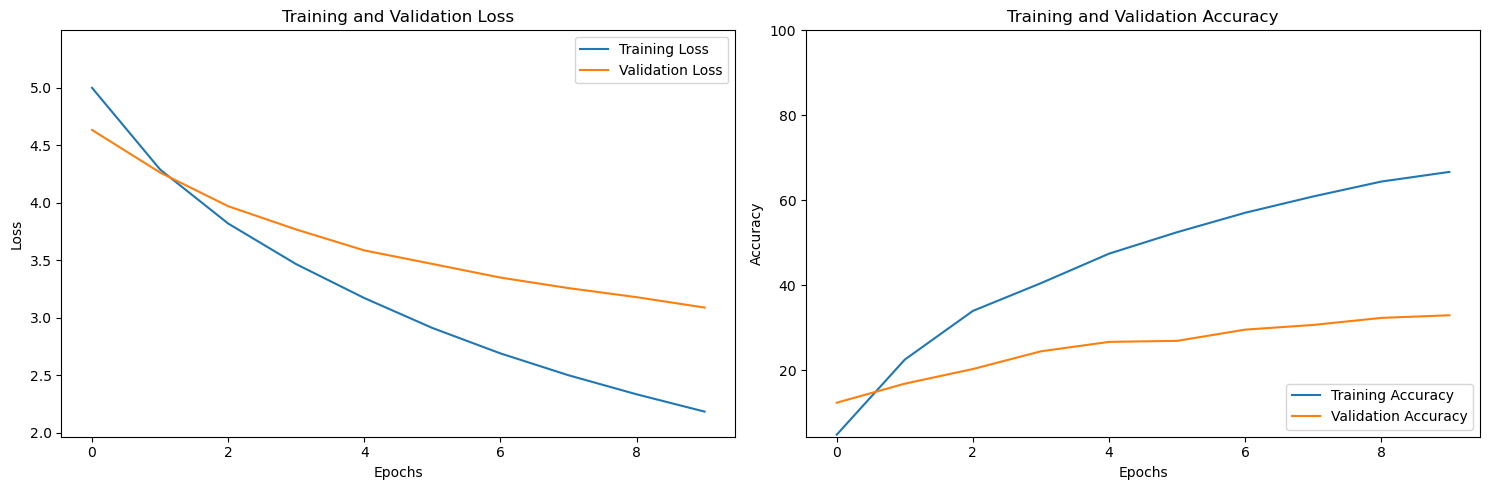

In [20]:
plt.figure(figsize=(15, 5))

# Plot Training and Validation Loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.ylim([min(min(train_losses), min(val_losses)) * 0.9, max(max(train_losses), max(val_losses)) * 1.1])
plt.title('Training and Validation Loss')

# Plot Training and Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.ylim([min(min(train_accuracies), min(val_accuracies)) * 0.9, 100])
plt.title('Training and Validation Accuracy')

plt.tight_layout()
plt.show()

In [21]:
test_dir = project_root / "data" / "test"

In [22]:
# Load the test dataset
test_data = ImageFolder(str(test_dir), transform=test_transformers)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

In [23]:
y_true, y_pred = [], []

model.eval()
correct = 0
total = 0
test_loss = 0.0
processed_images = 0

# Criterion has been defined above

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)

        # Predictions
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

        loss = criterion(outputs, labels)
        test_loss += loss.item()

        processed_images += labels.size(0)
        if processed_images % 500 == 0 or processed_images == total:
            print(f"Processed {processed_images} / {len(test_loader.dataset)} images...")

# Calculate metrics
test_loss /= len(test_loader)
test_accuracy = 100 * correct / total

logger.info(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Convert to DataFrame for better readability
cm_df = pd.DataFrame(cm, index=test_data.classes, columns=test_data.classes)

Processed 32 / 8041 images...
Processed 64 / 8041 images...
Processed 96 / 8041 images...
Processed 128 / 8041 images...
Processed 160 / 8041 images...
Processed 192 / 8041 images...
Processed 224 / 8041 images...
Processed 256 / 8041 images...
Processed 288 / 8041 images...
Processed 320 / 8041 images...
Processed 352 / 8041 images...
Processed 384 / 8041 images...
Processed 416 / 8041 images...
Processed 448 / 8041 images...
Processed 480 / 8041 images...
Processed 512 / 8041 images...
Processed 544 / 8041 images...
Processed 576 / 8041 images...
Processed 608 / 8041 images...
Processed 640 / 8041 images...
Processed 672 / 8041 images...
Processed 704 / 8041 images...
Processed 736 / 8041 images...
Processed 768 / 8041 images...
Processed 800 / 8041 images...
Processed 832 / 8041 images...
Processed 864 / 8041 images...
Processed 896 / 8041 images...
Processed 928 / 8041 images...
Processed 960 / 8041 images...
Processed 992 / 8041 images...
Processed 1024 / 8041 images...
Processed 

[02/01/25 12:00:46] INFO     INFO - Test Loss: 3.0702, Test Accuracy: 33.81%                       ]8;id=433525;file:///var/folders/jv/vqyftcs92v5_1kzvbv8kdcx40000gn/T/ipykernel_1471/2670826028.py\2670826028.py]8;;\:]8;id=929620;file:///var/folders/jv/vqyftcs92v5_1kzvbv8kdcx40000gn/T/ipykernel_1471/2670826028.py#35\35]8;;\

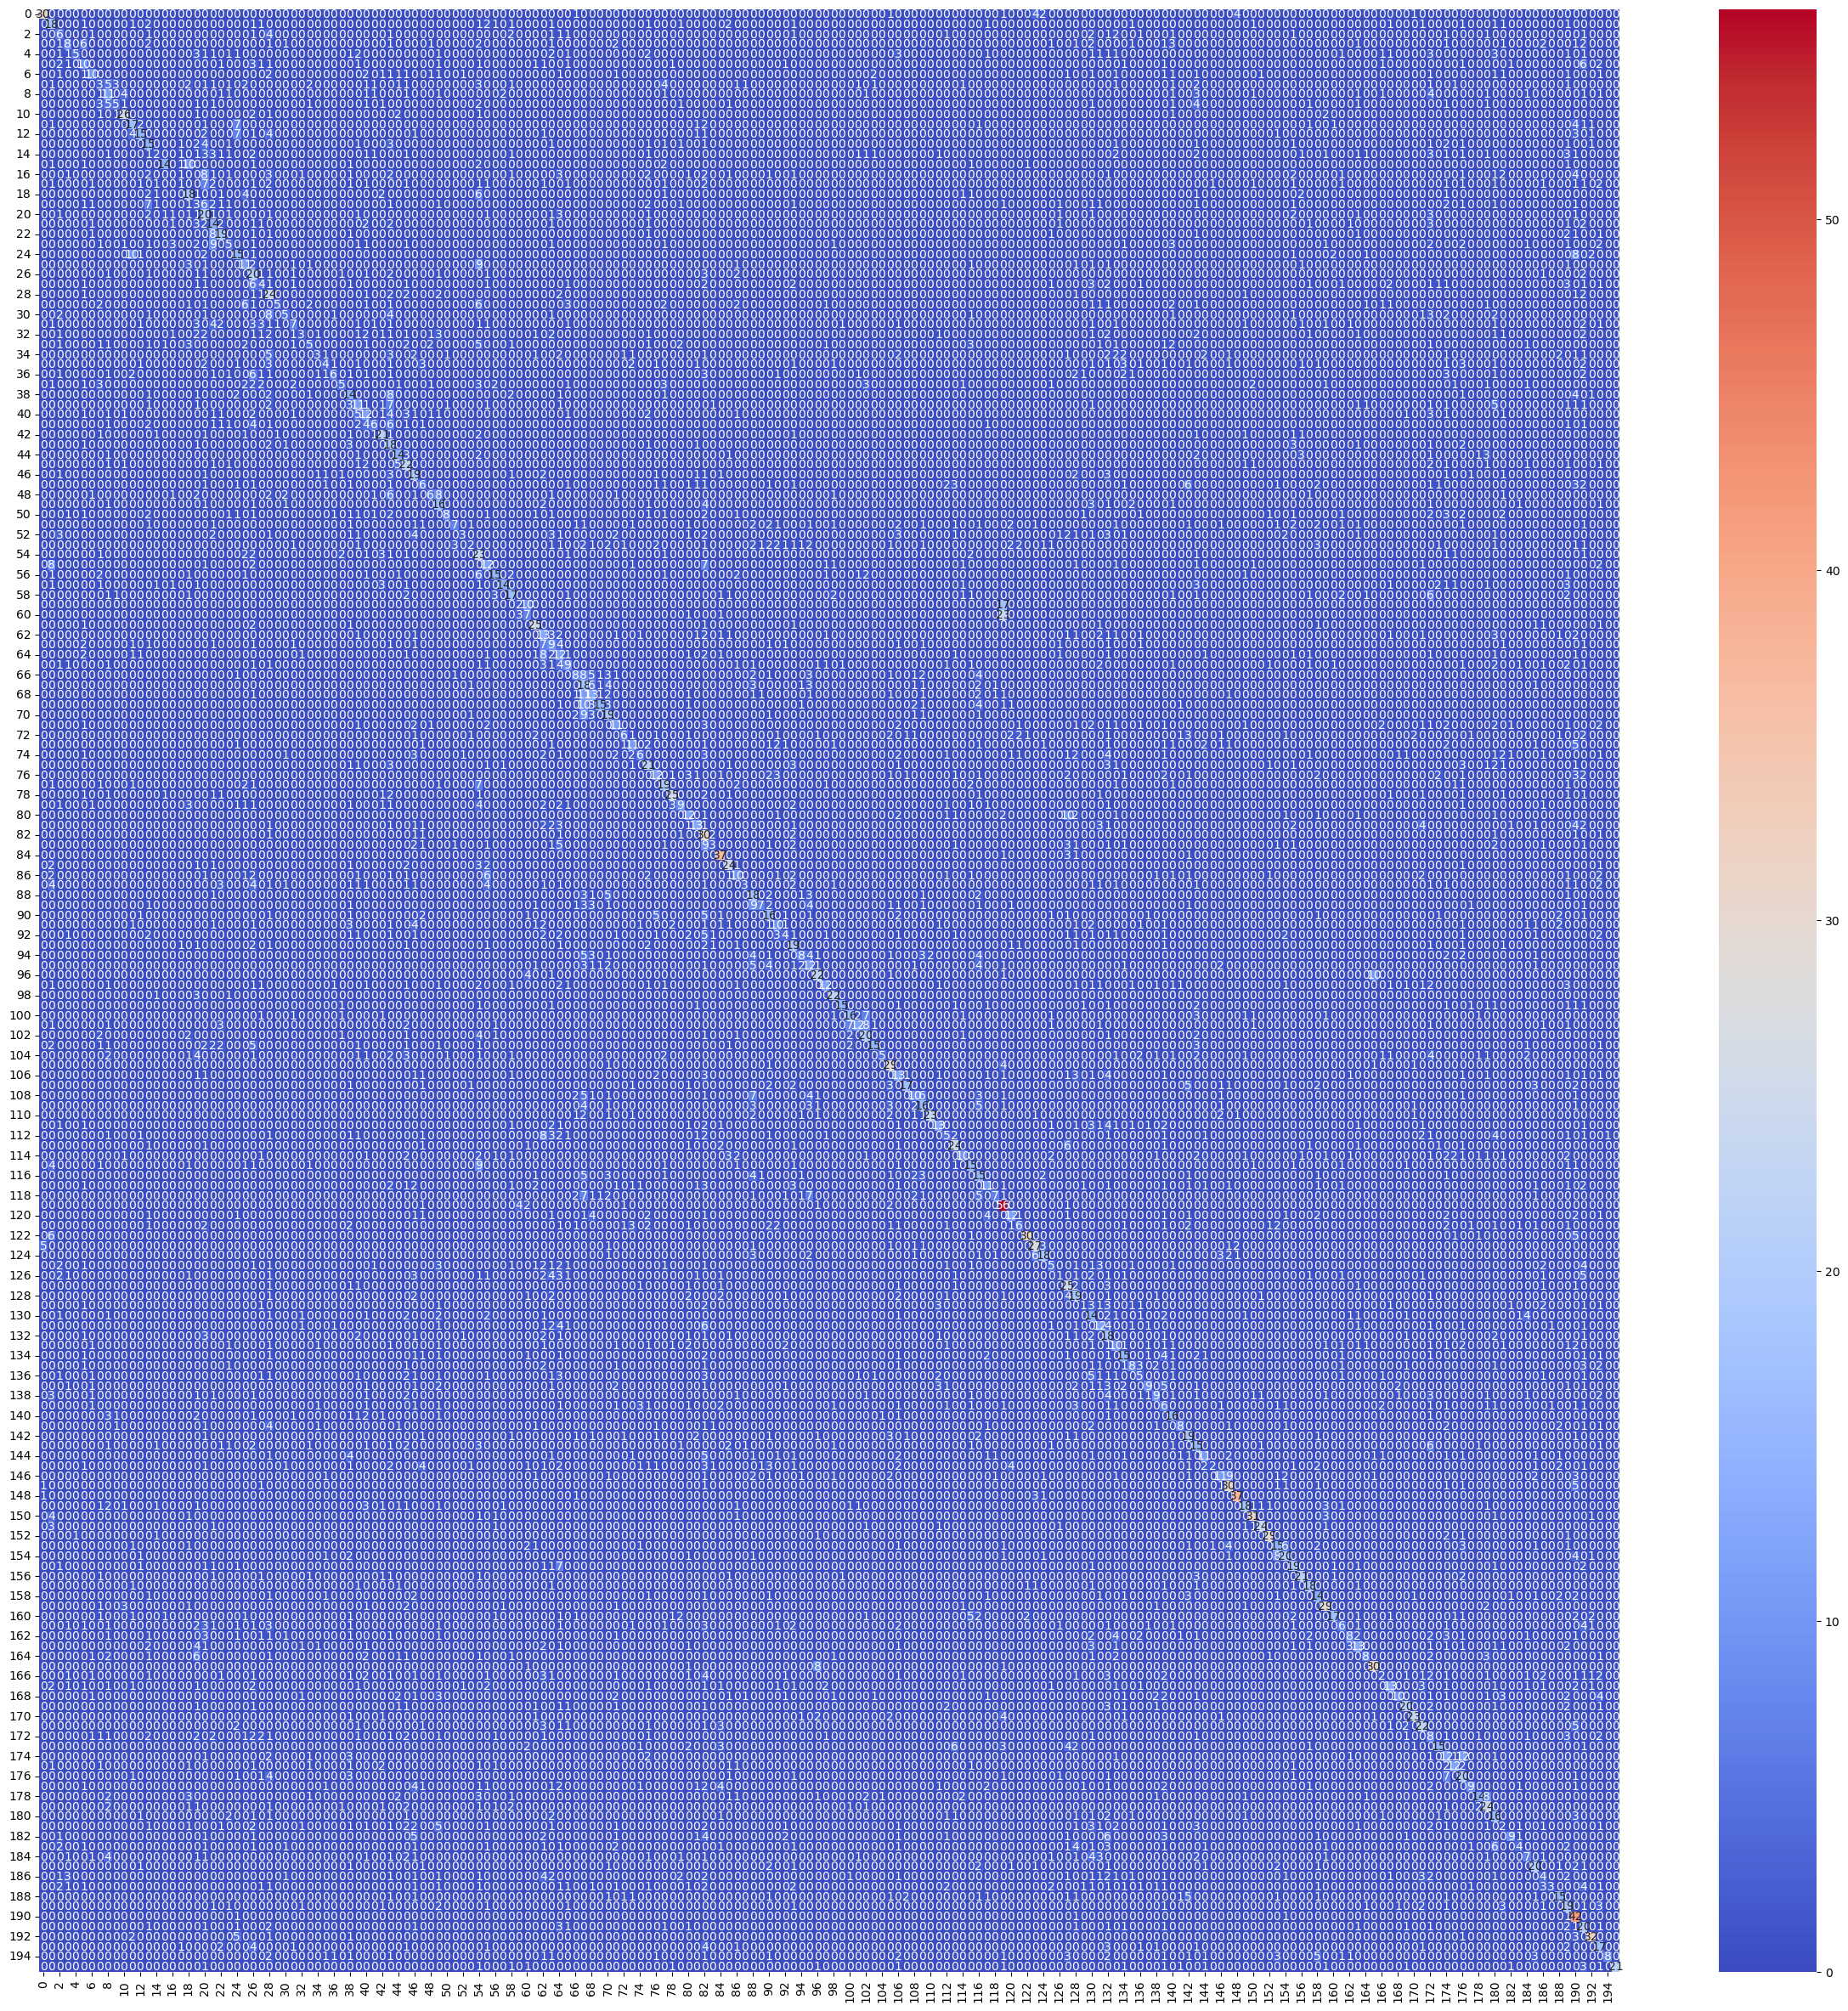

In [24]:
plt.figure(figsize=(30, 30))
sns.heatmap(cm, annot=True, fmt="d", cmap="coolwarm") 
plt.show()

In [25]:
# Flatten the confusion matrix DataFrame into a long format for filtering
cm_long = cm_df.reset_index().melt(id_vars='index', var_name='Predicted', value_name='Count')
cm_long = cm_long.rename(columns={'index': 'Actual'})

# Filter for misclassifications (Actual != Predicted) where the count is greater than 10
misclassified = cm_long[(cm_long['Actual'] != cm_long['Predicted']) & (cm_long['Count'] > 10)]

# Sort for better visibility
misclassified = misclassified.sort_values(by='Count', ascending=False)

# Display or save
logger.info(misclassified)

[02/01/25 12:00:59] INFO     INFO -                                               Actual  \        ]8;id=94984;file:///var/folders/jv/vqyftcs92v5_1kzvbv8kdcx40000gn/T/ipykernel_1471/3101041380.py\3101041380.py]8;;\:]8;id=152752;file:///var/folders/jv/vqyftcs92v5_1kzvbv8kdcx40000gn/T/ipykernel_1471/3101041380.py#12\12]8;;\
                             23384                     Chevrolet Express Van 2007                                  
                             23383               Chevrolet Express Cargo Van 2007                                  
                             34670                   Rolls-Royce Ghost Sedan 2012                                  
                             13200  Chevrolet Silverado 1500 Hybrid Crew Cab 2012                                  
                                                                                                                   
                                                                     Predicted  Count                              
                             23384                         GMC Savana Van 2012     23                              
                             23383                         GMC Savana Van 2012     17                              
                             34670              Rolls-Royce Phantom Sedan 2012     12                              
                             13200  Chevrolet Silverado 1500 Extended Cab 2012     11                              